In [1]:
import os
import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt

In [2]:
image_size = (180, 180)
batch_size = 4

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "img",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 49 files belonging to 4 classes.
Using 40 files for training.
Using 9 files for validation.


2024-10-08 15:11:02.144601: W tensorflow/core/framework/op_kernel.cc:1840] OP_REQUIRES failed at strided_slice_op.cc:117 : INVALID_ARGUMENT: slice index 4 of dimension 0 out of bounds.


InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:CPU:0}} slice index 4 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

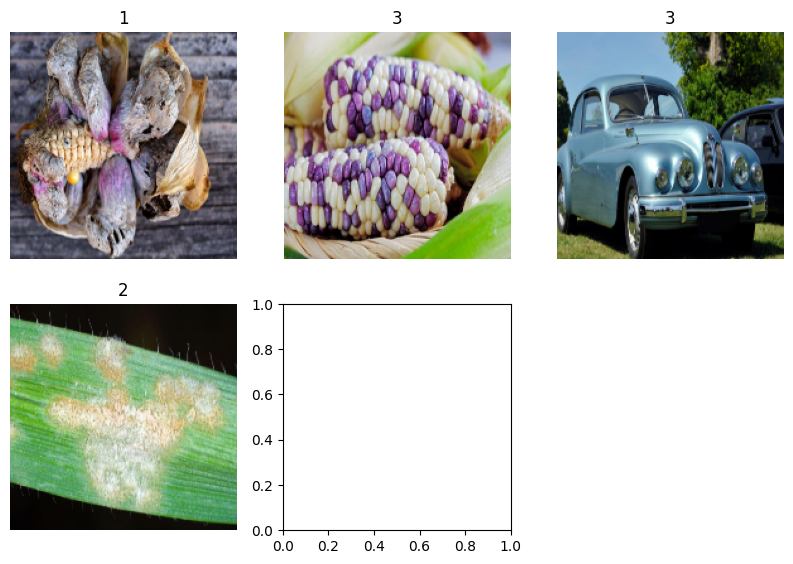

In [6]:

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(16):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [7]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]


def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images


2024-10-08 15:11:32.054459: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


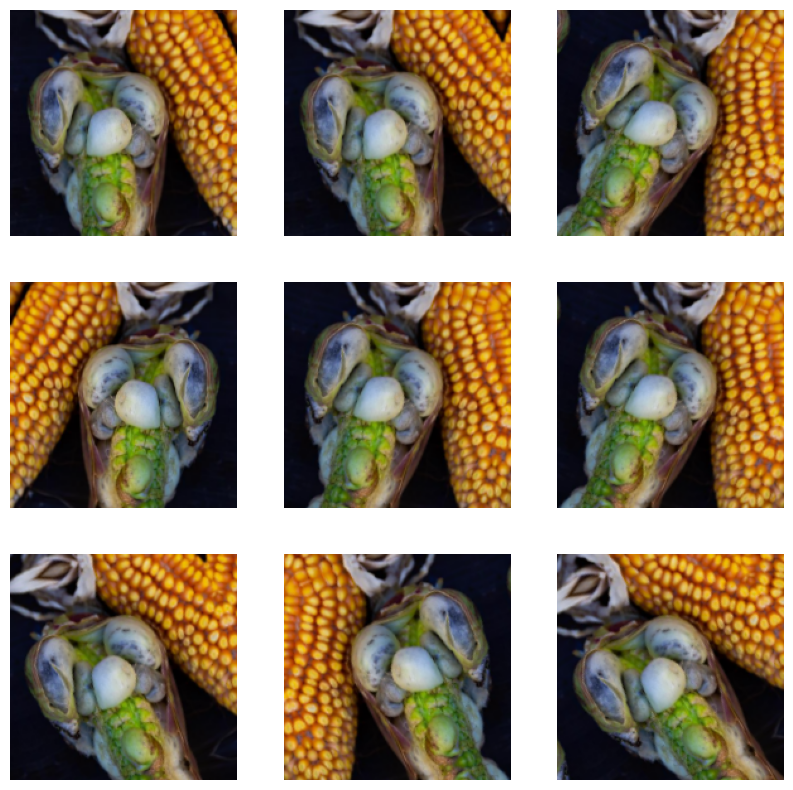

In [8]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")


In [9]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

In [10]:

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [ ]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("models/save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)
history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 511ms/step - acc: 0.2627 - loss: -24.8062 - val_acc: 0.1111 - val_loss: -1.0418
Epoch 2/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 514ms/step - acc: 0.3099 - loss: -31.4734 - val_acc: 0.1111 - val_loss: -1.2302
Epoch 3/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 476ms/step - acc: 0.2407 - loss: -35.3265 - val_acc: 0.1111 - val_loss: -1.2688
Epoch 4/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 507ms/step - acc: 0.4823 - loss: -20.9276 - val_acc: 0.1111 - val_loss: -1.3501
Epoch 5/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 500ms/step - acc: 0.2829 - loss: -33.5939 - val_acc: 0.1111 - val_loss: -1.5480
Epoch 6/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 485ms/step - acc: 0.2695 - loss: -38.4111 - val_acc: 0.1111 - val_loss: -1.5672
Epoch 7/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 515ms/step - acc: 0.2688 - loss: -53.0428 - val_acc: 0.1111 - val_loss: -1.3976
Epoch 8/25
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 519ms/step - acc: 0.1786 - loss: -59.8018 - val_acc: 0.1111 - val_loss: -1.0400
Epoch 9/25
10/10 ━━━━━━━━━━━━━━━